# Simulating noise on Amazon Braket

This notebook gives a detailed overview of noise simulations on Amazon Braket. Amazon Braket provides two noise simulators: a local noise simulator that you can use for free as part of the Braket SDK and a fully managed, high-performing noise simulator, DM1. Both simulators are based on the density matrix formalism. After this tutorial, you will be able to define noise channels, apply noise to new or existing circuits, and run those circuits on the Braket noise simulators. 

### Table of contents:
* [Background](#Background)
    * [Noise simulation based on the density matrix formalism](#density_matrix)
    * [Quantum channel and Kraus representation](#quantum_channel)
* [General imports](#imports)
* [Quick start](#start)
* [Defining noise channels](#noise_channels)
    * [Pre-defined noise channels](#pre-defined)
    * [Defining custom noise channels](#self-defined)
* [Adding noise to a circuit](#apply_noise)
    * [Build noisy circuits bottom-up](#apply_noise_directly)
    * [Applying noise to existing circuits with global methods](#apply_noise_globally)
        * [Applying gate noise to the circuit](#gate-noise)
        * [Applying initialization noise to the circuit](#initialization-noise)
        * [Applying readout noise to the circuit](#readout-noise)
    * [Using both the direct and global methods to apply noise](#both)
* [Running a noisy circuit](#run)

### Resources
* [Blog] https://aws.amazon.com/about-aws/whats-new/2021/05/amazon-braket-introduces-quantum-circuit-noise-simulator-dm1/

## Background <a class="anchor" id="Background"></a>

### Noise simulation based on the density matrix formalism <a class="anchor" id="density_matrix"></a>
In an ideal case, a quantum state prepared by a noise-free circuit can be described by a state vector $|\psi\rangle$ -- we call it a 'pure state'. However, the presence of noise in realistic quantum devices will introduce classical uncertainty to the quantum state. For example, a bit flip error with 50% probability acting on a qubit flips the $|0\rangle$ state into either $|0\rangle$ or $|1\rangle$ with a 50-50 chance. Note that this is different from an Hadamard-gate acting on $|0\rangle$: The latter results in a coherent superposition of $|0\rangle$ and $|1\rangle$, whereas the former is a classical, so-called mixture of $|0\rangle$ and $|1\rangle$. The most general way of describing a quantum state in the presence of noise is through the so-called density matrix: $\rho = \sum_i p_i|\psi_i\rangle\langle\psi_i|$. It can be understood as a classical mixture of a series of pure states $|\psi_i\rangle$ (each of which could be highly entangled), where $p_i$ is the probability of the state being in $|\psi_i\rangle$. Because the $p_i$ are classical probabilities they have to sum up to 1: $\sum_i p_i = 1$. The density matrix of a pure state is simply $\rho = |\psi\rangle\langle\psi|$ and, in the bit-flip example from above, the density matrix would be $\rho = 0.5|0\rangle\langle 0| + 0.5|1\rangle\langle 1|$. 

The density matrix formalism is a very useful way to describe a noisy system with probabilistic outcomes. It gives an exact description of a quantum system going through a quantum channel with noise. Besides, the expectation value of an observable $\langle O\rangle$ can be easily calculated by $\rm{Tr}(O\rho)$, where "$\rm{Tr}$" is the trace operator. 

### Quantum channel and Kraus representation <a class="anchor" id="quantum_channel"></a>

A [quantum channel](https://en.wikipedia.org/wiki/Quantum_channel) describes the time evolution of a quantum state which is expressed as a density matrix. For instance, to understand what a series of noisy gates does to the state of a quantum computer, you can apply a quantum channel corresponding to the different gate and noise operations. 
Mathematically speaking, a quantum channel is a completely positive and trace-preserving (CPTP) linear map acting on a density matrix. Completely positive means the channel maps positive operators into positive operators (even if the operator is applied to part of a larger system) to make sure the density matrix describes a proper quantum state after the map. Trace-preserving means the trace of the density matrix remains unchanged during the mapping process (this is so that after the map the classical probabilities $p_i$ still sum to 1). 

The so-called _Kraus representation_ is a commonly used representation for CPTP maps. [Kraus's theorem](https://en.wikipedia.org/wiki/Quantum_operation#Kraus_operators) states that any quantum operation acting on a quantum state $\rho$ can be expressed as a map $\varepsilon(\rho) = \sum_i K_i\rho K_i^{\dagger}$, and it satisfies: $\sum_i K_i^{\dagger}K_i = \mathbb{1}$, where $\mathbb{1}$ is the Identity operator.

Let's get started and have a look how you can define and simulate noisy circuits on Amazon Braket.

## General imports <a class="anchor" id="imports"></a>

Let's begin with the usual imports and setting our s3 location where we want to persist results.

In [1]:
from braket.circuits import Circuit, Observable, Gate, Noise
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import unitary_group

<div class="alert alert-block alert-info">
    <b>Note</b> Enter your desired S3 location (bucket and prefix). Remember that bucket names for Amazon Braket always begin with "amazon-braket-". 
</div>


In [2]:
# enter the S3 bucket you created during onboarding (or any other bucket starting with "amazon-braket-") 
my_bucket = # TODO:  Fill in the name of the bucket
my_prefix = "demo" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

## Quick start <a class="anchor" id="start"></a>

Let's start with a simple example of running a noisy circuit on Amazon Braket. 

measurement results: Counter({'00': 424, '11': 400, '10': 88, '01': 88})


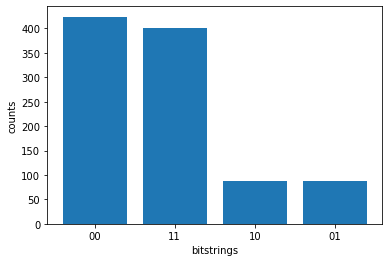

In [3]:
# build a simple circuit
circ = Circuit().h(0).cnot(0,1)

# define a noise channel
noise = Noise.BitFlip(probability=0.1)

# add noise to every gate in the circuit
circ.apply_gate_noise(noise)

# select the local noise simulator
device = LocalSimulator('braket_dm')

# run the circuit on the local simulator
task = device.run(circ, shots = 1000)

# visualize the results
result = task.result()
counts = result.measurement_counts
print('measurement results:', counts)

# plot using Counter
plt.bar(counts.keys(), counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');

Ideally, in the noise-free case, the circuit we defined prepares a Bell-state, and we would expect to measure only '00' and '11' outcomes. However, the presence of noise, in our case a bit flip error, means that sometimes we find the state in '01' and '10' instead.

The local simulator is suitable for fast prototyping on small circuits. If you want to run a noisy circuit with more than 10~12 qubits, we recommend using the managed simulator DM1. Using DM1, you can run circuits with up to 17 qubits, and benefit from parallel execution for a group of circuits. The code below shows an example of preparing a 13-qubit GHZ state in the presence of noise.

## Defining noise channels <a class="anchor" id="noise_channels"></a>

To apply noise to a quantum circuit, first, you need to define the noise channel, which is defined in Kraus representation. We offer many commonly-used noise channels in the `Noise` class of the [Amazon Braket SDK](https://amazon-braket-sdk-python.readthedocs.io/en/latest/_apidoc/braket.circuits.html). In addition, you can also define your own custom noise channel as a list of Kraus operators.

### Pre-defined noise channels <a class="anchor" id="pre-defined"></a>

The pre-defined single-qubit noise channels include `BitFlip`, `PhaseFlip`, `Depolarizing`, `AmplitudeDamping`, `GeneralizedAmplitudeDamping`, `PhaseDamping` and `PauliChannel`. 
The pre-defined two-qubit noise channels include `TwoQubitDepolarizing` and `TwoQubitDephasing`. The Kraus representations for all of the pre-defined channels are summarized in the following table.

__single-qubit noise channels__

| Noise channel  | <div style="width:290px">Kraus representation</div> | Parameter   |
|:-------------- |:--------------------------------------------------  |:------------|
|   `BitFlip`     |  $(1-p)\rho$ + $pX\rho X$| $p$ is the probability of the bit flip noise.   |
|   `PhaseFlip`   |  $(1-p)\rho$ + $pZ\rho Z$| $p$ is the probability of the phase flip noise. |
| `Depolarizing`  |$(1-p)\rho$ + $p/3(X\rho X$ + $Y\rho Y$ + $Z\rho Z)$|$p$ is the probability of the depolarizing noise (the three possible error cases share the same probability of $p/3$).|
|`AmplitudeDamping`|$K_0\rho K_0^\dagger$ + $K_1\rho K_1^\dagger$|$K_0=[1,0;0,\sqrt{1-\gamma}]$, $K_1=[0,\sqrt{\gamma};0,0]$, where $\gamma$ is the rate of amplitude damping.|
|`GeneralizedAmplitudeDamping`|$K_0\rho K_0^\dagger$ + $K_1\rho K_1^\dagger$ + $K_2\rho K_2^\dagger$ + $K_3 \rho K_3^\dagger$|$K_0=\sqrt{p}[1,0;0,\sqrt{1-\gamma}]$, $K_1=\sqrt{p}[0,\sqrt{\gamma};0,0]$, $K_2=\sqrt{1-p}[\sqrt{1-\gamma},0;0,1]$, $K_3=\sqrt{1-p}[0,0;\sqrt{\gamma},0]$, where $\gamma$ is the rate of amplitude damping, and $p$ is the probability of the system been excited by the environment [1].|
|`PhaseDamping`|$K_0\rho K_0^\dagger$ + $K_1 \rho K_1^\dagger$|$K_0=[1,0;0,\sqrt{1-\gamma}]$, $K_1=[0,0;0,\sqrt{\gamma}]$, where $\gamma$ is the rate of phase damping.|
|`PauliChannel`|$(1-p_x-p_y-p_z)\rho$ + $p_xX\rho X$ + $p_yY\rho Y$ + $p_zZ\rho Z$|$p_x$, $p_y$ and $p_z$ are probabilities for the Pauli X, Y, Z noise respectively.|


__two-qubit noise channels__

|<div style="width:160px">Noise channel</div>| <div style="width:290px">Kraus representation</div> | Parameter  |
|:----------------------- |:--------------------------------------------------  |:------------|
|   `TwoQubitDepolarizing`|  $(1-p)\rho$ + $p/15(IX\rho IX$ + $IY\rho IY$ + $IZ\rho IZ$ + $XI\rho XI$ +....+ $ZZ\rho ZZ)$| $p$ is the probability of the two-qubit depolarizing noise (the 15 possible error combinations share the same probability of $p/15$).|
|   `TwoQubitDephasing`   |  $(1-p)\rho$ + $p/3(IZ\rho IZ$ + $ZI\rho ZI$ + $ZZ\rho ZZ)$| $p$ is the probability of the two-qubit dephasing noise (the three possible error combinations share the same probability of $p/3$). |

The following code block takes the example of the bit flip noise channel: $\rho\rightarrow(1-p)\rho$ + $pX\rho X$, where $p$ corresponds to the `probability` parameter when defining the noise. This noise channel is equivalent to applying a bit flip error (applying an X gate) with probability $p$ and doing nothing with probability $1-p$. You can check the target qubit count and the Kraus operators of the noise channel defined.

In [4]:
# define a bit flip noise channel with probability = 0.1
noise = Noise.BitFlip(probability=0.1)

print('name: ', noise.name)
print('qubit count: ', noise.qubit_count)
print('Kraus operators: ')
for matrix in noise.to_matrix():
    print(matrix, '\n')


name:  BitFlip
qubit count:  1
Kraus operators: 
[[0.9486833+0.j 0.       +0.j]
 [0.       +0.j 0.9486833+0.j]] 

[[0.        +0.j 0.31622777+0.j]
 [0.31622777+0.j 0.        +0.j]] 



Other pre-defined noise channels can be used in a similar way:

In [5]:
# define a phase flip noise channel
noise = Noise.PhaseFlip(probability=0.1)
# define a single-qubit depolarizing noise channel
noise = Noise.Depolarizing(probability=0.1)
# define a two-qubit depolarizing noise channel
noise = Noise.TwoQubitDepolarizing(probability=0.1)
# define a two-qubit dephasing noise channel
noise = Noise.TwoQubitDephasing(probability=0.1)
# define an amplitude damping noise channel
noise = Noise.AmplitudeDamping(gamma=0.1)
# define a generalized amplitude damping noise, where gamma is the amplitude damping rate, and
# probability is the probability of the system being excited by the environment.
noise = Noise.GeneralizedAmplitudeDamping(gamma=0.1, probability=0.1)
# define a phase damping noise channel
noise = Noise.PhaseDamping(gamma=0.1)
# define a Pauli noise channel
noise = Noise.PauliChannel(probX=0.1, probY=0.2, probZ=0.3)

### Defining custom noise channels <a class="anchor" id="self-defined"></a>
Apart from the pre-defined noise models, you can also define your own noise model by specifying a list of Kraus operators. The following code shows an example of defining a two-qubit Kraus channel with randomly generated unitary operators.

In [6]:
# creat an arbitrary 2-qubit Kraus matrix
E0 = unitary_group.rvs(4) * np.sqrt(0.2) 
E1 = unitary_group.rvs(4) * np.sqrt(0.8)
K = [E0, E1] 

# define a two-qubit noise channel with Kraus operators
noise = Noise.Kraus(K) 

Note that the noise channel you define needs to form a CPTP map. If the input matrices do not define a CPTP map, an error will be raised.

In [7]:
K_invalid = [np.random.randn(2,2), np.random.randn(2,2)] 

try:
    noise = Noise.Kraus(K_invalid)
    pass
except ValueError as err:
    print(err)

The input matrices do not define a completely-positive trace-preserving map.


## Adding noise to a circuit <a class="anchor" id="apply_noise"></a>

There are two methods to build a 'noisy' circuit. First, you can add noise to the circuit 'bottom-up', by using the noise operations in the same way as you would add a gate to the circuit. Second, you can use the methods `apply_gate_noise()`, `apply_initialization_noise()` and `apply_readout_noise()` to apply gate error, qubit initialization error and measurement error globally to existing circuits. 

The direct method is more flexible as you can apply noise to any place in a circuit. But for an existing large circuit with lots of gates, you may want to use the global methods to conveniently apply noise to the circuit.


### Build noisy circuits bottom-up  <a class="anchor" id="apply_noise_directly"></a>
Noise channels can be applied to the circuit the same way as gates. The following example shows how to apply single- and two-qubit noise channels directly to a circuit. The noise applied can be visualized in the circuit diagram with the `print()` method.

In [8]:
# apply depolarizing noise
circ = Circuit().x(0).x(1).cnot(0,1).depolarizing(1, probability=0.2).x(0).two_qubit_dephasing(target1=0, target2=1, probability=0.1)
print(circ)

T  : |0|     1     |     2     |
                                
q0 : -X-C-----------X-DEPH(0.1)-
        |             |         
q1 : -X-X-DEPO(0.2)---DEPH(0.1)-

T  : |0|     1     |     2     |


### Applying noise to existing circuits with global methods<a class="anchor" id="apply_noise_globally"></a>

We offer three methods to apply noise globally to the circuit: `apply_gate_noise()`, `apply_initialization_noise()` and `apply_readout_noise()`. In the following, we explain in detail the usage of these three methods.

#### Applying gate noise to the circuit <a class="anchor" id="gate-noise"></a>

`apply_gate_noise()` is the method to conveniently apply gate-noise to the circuit. It accepts the following input parameters:

- __noise__: A single or a list of noise channel in `Noise` type.
- __target_unitary__: A single unitary gate in the form of a matrix in `numpy.ndarray` type. The noise will be applied to that unitary gate. 
- __target_gates__: A single or a list of gates in `Gate` type. Note that `target_gates` and `target_unitary` can not be provided at the same time. If none of `target_gates` and `target_unitary` is given, noise will be applied to all the gates in the circuit. 
- __target_qubits__: A single or a list of qubit indexes. If not given, noise will be applied to all the qubits in the circuit.

When calling the method, the noise channel(s) will be applied right after all `target_gates` in `target_qubits`.

<div class="alert alert-block alert-info">
    <b>Note</b> When you call this method, noise will be inserted right after the gate. If you like to apply more than one noise operation, be aware of the order. Alternatively, you can provide a list of noise operations in one call, and the noise will be applied in forward order. 
</div>

The code below is an example of applying phase damping noise to all gates in the circuit.

In [9]:
noise = Noise.PhaseDamping(gamma=0.1)

# the noise channel is applied to every gate in the circuit
circ = Circuit().x(0).bit_flip(0,0.1).cnot(0,2)
circ.apply_gate_noise(noise)
print('Noise is applied to every gate in the circuit:\n')
print(circ)

Noise is applied to every gate in the circuit:

T  : |        0        |    1    |
                                  
q0 : -X-PD(0.1)-BF(0.1)-C-PD(0.1)-
                        |         
q2 : -------------------X-PD(0.1)-

T  : |        0        |    1    |


If you want to apply noise to some particular gates in the circuit, you can specify them as `target_gates`. Below is an example in which noise is applied to all X gates in the circuit.

<div class="alert alert-block alert-info">
    <b>Note</b> The <code>target_gates</code> must be a <code>Gate</code> type. You can find all available gates with the following commands:
    
<code>
from braket.circuits import Gate
gate_set = [attr for attr in dir(Gate) if attr[0] in string.ascii_uppercase]
print(gate_set)
</code>
</div>

In [10]:
# the noise channel is applied to all the X gates in the circuit
circ = Circuit().x(0).y(1).cnot(0,2).x(1).z(2)
circ.apply_gate_noise(noise, target_gates = Gate.X)
print('Noise is applied to every X gate:\n')
print(circ)

Noise is applied to every X gate:

T  : |    0    |     1     |2|
                              
q0 : -X-PD(0.1)-C-------------
                |             
q1 : -Y---------|-X-PD(0.1)---
                |             
q2 : -----------X-----------Z-

T  : |    0    |     1     |2|


If you define custom unitary gates as part of your circuit, and you want to apply noise to them, you can use the `target_unitary` criterion.

In [11]:
U1=unitary_group.rvs(4)
U2=unitary_group.rvs(4)
circ = Circuit().x(0).y(1).unitary((0,1),U1).cnot(0,2).x(1).z(2).unitary((1,2),U2)
circ.apply_gate_noise(noise, target_unitary = U2)
print('Noise is applied to U2:\n')
print(circ)

Noise is applied to U2:

T  : |0|1| 2 |3|    4    |
                          
q0 : -X-U-C---------------
        | |               
q1 : -Y-U-|-X---U-PD(0.1)-
          |     |         
q2 : -----X---Z-U-PD(0.1)-

T  : |0|1| 2 |3|    4    |


If you want to apply noise to some particular qubits in the circuit, you can specify them as `target_qubits`. Below is an example to apply noise to all gates in qubits 0 and 2 in the circuit.

In [12]:
# the noise channel is applied to every gate on qubits 0 and 2
circ = Circuit().x(0).y(1).cnot(0,2).x(1).z(2)
circ.apply_gate_noise(noise, target_qubits = [0,2])
print('Noise is applied to every gate in qubits 0 and 2:\n')
print(circ)

Noise is applied to every gate in qubits 0 and 2:

T  : |    0    |    1    |    2    |
                                    
q0 : -X-PD(0.1)-C-PD(0.1)-----------
                |                   
q1 : -Y---------|-X-----------------
                |                   
q2 : -----------X-PD(0.1)-Z-PD(0.1)-

T  : |    0    |    1    |    2    |


The `target_qubits` and `target_gates` criteria can be used at the same time. The code block below applies the gate noise to all X gates in qubit 0.

In [13]:
# the noise channel is applied to X gate on qubits 0
circ = Circuit().x(0).y(1).cnot(0,2).x(0).x(1).z(2)
circ.apply_gate_noise(noise, target_gates = Gate.X, target_qubits = 0)
print('Noise is applied to X gates in qubits 0:\n')
print(circ)

Noise is applied to X gates in qubits 0:

T  : |    0    | 1 |    2    |
                              
q0 : -X-PD(0.1)-C---X-PD(0.1)-
                |             
q1 : -Y---------|-X-----------
                |             
q2 : -----------X---Z---------

T  : |    0    | 1 |    2    |


If a list of noise channels is provided, the first noise channel in the list will be applied first, then the second.  

In [14]:
# define two noise channels
noise1 = Noise.Depolarizing(probability=0.1)
noise2 = Noise.BitFlip(probability=0.2)

# apply a list of noise channels 
circ = Circuit().x(0).y(1).cnot(0,2).x(1).z(2)
circ.apply_gate_noise([noise1, noise2], target_qubits = [0,1])
print('Noise channels are applied to every gate in qubits 0 and 1:\n')
print(circ)

Noise channels are applied to every gate in qubits 0 and 1:

T  : |         0         |              1              |2|
                                                          
q0 : -X-DEPO(0.1)-BF(0.2)-C-DEPO(0.1)-BF(0.2)-------------
                          |                               
q1 : -Y-DEPO(0.1)-BF(0.2)-|-X---------DEPO(0.1)-BF(0.2)---
                          |                               
q2 : ---------------------X-----------------------------Z-

T  : |         0         |              1              |2|


If you want to apply multi-qubit noise channels to a gate, the number of qubits associated with the gate must equal to the number of qubits defined by the noise channel, or otherwise the noise will not be applied. Below shows an example.

In [15]:
# define a two-qubit noise channel
noise = Noise.TwoQubitDephasing(probability=0.1)

# apply the noise to the circuit
circ = Circuit().x(0).y(1).cnot(0,2).x(1).z(2).swap(1,0)
circ.apply_gate_noise(noise)
print('The two-qubit noise channel is applied to all the two-qubit gates in the circuit:\n')
print(circ)

The two-qubit noise channel is applied to all the two-qubit gates in the circuit:

T  : |0|      1      |      2       |
                                     
q0 : -X-C-DEPH(0.1)---SWAP-DEPH(0.1)-
        | |           |    |         
q1 : -Y-|-|---------X-SWAP-DEPH(0.1)-
        | |                          
q2 : ---X-DEPH(0.1)---Z--------------

T  : |0|      1      |      2       |


#### Applying initialization noise to the circuit <a class="anchor" id="initialization-noise"></a>

`apply_initialization_noise()` is the method to apply initialization noise to the circuit. By using the method, the noise will be applied to every qubit at the beginning of a circuit. It accepts the following input parameters:

- __noise__: a single or a list of noise channel in `Noise` type.
- __target_qubits__: a single or a list of qubit indexes. If not given, noise will be applied to all the qubits in the circuit.

If you want to apply the initialization noise to an empty circuit, you need to provide `target_qubits` to the method. 

<div class="alert alert-block alert-info">
    <b>Note</b> When you call this method, noise will be inserted at the very beginning of the circuit. If you like to apply more than one noise operation, be aware of the order. Alternatively, you can provide a list of noise operations in one call, and the noise will be applied in forward order. 
</div>

In [16]:
# define a noise channel
noise = Noise.Depolarizing(probability=0.1)

# the noise channel is applied as the initialization noise to the circuit
circ = Circuit().x(0).y(1).cnot(0,2).x(1).z(2)
circ.apply_initialization_noise(noise)
print('Initialization noise is applied to the circuit:\n')
print(circ)

Initialization noise is applied to the circuit:

T  : |     0     | 1 |2|
                        
q0 : -DEPO(0.1)-X-C-----
                  |     
q1 : -DEPO(0.1)-Y-|-X---
                  |     
q2 : -DEPO(0.1)---X---Z-

T  : |     0     | 1 |2|


If you want to apply a multi-qubit noise channel as the initialization noise to a circuit and if the number of the qubits in the existing circuit doesn't match the number of qubits as defined by the noise channel, you need to provide `target_qubits` with the number of qubits matching the noise channel. 

In [17]:
# define a two-qubit noise channel
noise = Noise.TwoQubitDephasing(probability=0.1)

# the noise channel is applied as the initialization noise to the circuit
circ = Circuit().x(0).y(1).cnot(0,1).x(1).z(0)
circ.apply_initialization_noise(noise)
print('Initialization noise is applied to the circuit:\n')
print(circ)

Initialization noise is applied to the circuit:

T  : |     0     |1|2|
                      
q0 : -DEPH(0.1)-X-C-Z-
      |           |   
q1 : -DEPH(0.1)-Y-X-X-

T  : |     0     |1|2|


#### Applying readout noise to the circuit <a class="anchor" id="readout-noise"></a>

The method of `apply_readout_noise()` is very similar to the method to apply initialization noise, except that the noise channel is applied to every qubit in the end of a circuit. It accepts the following input parameters:

- __noise__: a single or a list of noise channel in `Noise` type.
- __target_qubits__: a single or a list of qubit indexes. If not given, noise will be applied to all the qubits in the circuit.

If you want to apply the readout noise to an empty circuit, you need to provide `target_qubits` to the method. 

<div class="alert alert-block alert-info">
    <b>Note</b> When you call this method, noise will be inserted at the very end of the circuit. If you like to apply more than one noise operation, be aware of the order. You can also provide a list of noise operations in the one call, and the noise will be applied in forward order. 
</div>

In [18]:
# define a noise channel
noise = Noise.Depolarizing(probability=0.1)

# the noise channel is applied as the readout noise to the circuit
circ = Circuit().x(0).y(1).cnot(0,2).x(1).z(2)
circ.apply_readout_noise(noise)
print('Read-out noise is applied to the circuit:\n')
print(circ)

Read-out noise is applied to the circuit:

T  : |0| 1 |         2         |
                                
q0 : -X-C---DEPO(0.1)-----------
        |                       
q1 : -Y-|-X-DEPO(0.1)-----------
        |                       
q2 : ---X---Z---------DEPO(0.1)-

T  : |0| 1 |         2         |


If you want to apply a multi-qubit noise channel as the readout noise to a circuit and if the number of the qubits in the existing circuit doesn't match the number of qubits as defined by the noise channel, you need to provide `target_qubits` with the number of qubits matching the noise channel. 

### Using both the direct and global methods to apply noise <a class="anchor" id="both"></a>
You can apply noise to the circuit using both the direct and global methods. 

In [19]:
# define a noise channel
noise = Noise.PhaseFlip(probability=0.2)

# create a circuit and add noise directly to the circuit
circ = Circuit().x(0).y(1).bit_flip(0,0.1).cnot(1,2).two_qubit_depolarizing(1, 2, probability=0.1).z(2)
circ.apply_gate_noise(noise, target_qubits=0)
print('Noise channels are applied to the circuit:\n')
print(circ)

Noise channels are applied to the circuit:

T  : |        0        |     1     |2|
                                      
q0 : -X-PF(0.2)-BF(0.1)---------------
                                      
q1 : -Y-----------------C-DEPO(0.1)---
                        | |           
q2 : -------------------X-DEPO(0.1)-Z-

T  : |        0        |     1     |2|


## Running a noisy circuit <a class="anchor" id="run"></a>

Running a noisy circuit is like running any other task on Amazon Braket. In the example below we will pick the local simulator to run our circuit. 

With shots = 0, you can obtain the exact values of probability, density matrix and expectation values of the mixed state by attaching the corresponding result type. The reduced density matrix is also available if providing the targets qubits. If no target qubit is provided, the full density matrix will be returned. 

An example is shown in the code block below.

In [20]:
# define the noise channel
noise = Noise.AmplitudeDamping(gamma=0.1)
# create a circuit
circ = Circuit().x(0).y(1).cnot(0,2).x(1).z(2)
# apply the noise to qubits 0 and 2 in the circuit 
circ.apply_gate_noise(noise, target_qubits = [0,2])

# attach the result types
circ.probability()
circ.expectation(observable = Observable.Z(),target=0)
# attach the density matrix with target=[0,1], and the reduced density matrix of qubits 0,1 will be returned
circ.density_matrix(target=[0,1])
print(circ)

# choose the noise simualtor, which is called "braket_dm"
device = LocalSimulator("braket_dm")
# run the circuit
task = device.run(circ, shots=0)
result = task.result()


print('- Probability is: ')
print(result.values[0])
print('- Expectation value <Z_0> is: ')
print(result.values[1])
print('- The reduced Density Matrix is: ')
print(result.values[2])

T  : |    0    |    1    |    2    |              Result Types              |
                                                                             
q0 : -X-AD(0.1)-C-AD(0.1)-----------Probability-Expectation(Z)-DensityMatrix-
                |                   |                          |             
q1 : -Y---------|-X-----------------Probability----------------DensityMatrix-
                |                   |                                        
q2 : -----------X-AD(0.1)-Z-AD(0.1)-Probability------------------------------

T  : |    0    |    1    |    2    |              Result Types              |
- Probability is: 
[0.1171 0.0729 0.     0.     0.1539 0.6561 0.     0.    ]
- Expectation value <Z_0> is: 
-0.6199999999999997
- The reduced Density Matrix is: 
[[0.19+0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.81+0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j]]


With shots > 0, the results are sampled from the probability distributions. The result type `density_matrix` is not available for shots > 0. 

The code below shows the expectation value $\langle Z_0\rangle$ and the probability that the mixed state collapsing into different states. We see those values here are different from the exact values obtained in the shots = 0 case.

In [21]:
# create a circuit
circ = Circuit().x(0).y(1).cnot(0,2).x(1).z(2)
circ.apply_gate_noise(noise, target_qubits = [0,2])

circ.probability()
circ.expectation(observable = Observable.Z(),target=0)
print(circ)

# run the circuit
task = device.run(circ, shots=100)
result = task.result()

print('- Probability is: ')
print(result.values[0])
print('- Expectation value <Z_0> is: ')
print(result.values[1])

T  : |    0    |    1    |    2    |       Result Types       |
                                                               
q0 : -X-AD(0.1)-C-AD(0.1)-----------Probability-Expectation(Z)-
                |                   |                          
q1 : -Y---------|-X-----------------Probability----------------
                |                   |                          
q2 : -----------X-AD(0.1)-Z-AD(0.1)-Probability----------------

T  : |    0    |    1    |    2    |       Result Types       |
- Probability is: 
[0.14 0.08 0.   0.   0.18 0.6  0.   0.  ]
- Expectation value <Z_0> is: 
-0.56


## Reference
[1] Srikanth R, Banerjee S. "Squeezed generalized amplitude damping channel", Physical Review A, 2008, 77(1): 012318.